# Programming Assignment 4: Clustering Analysis


In [1]:
import os
import cv2
import torch
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xml.etree.ElementTree as ET
import warnings
import ssl
import warnings

ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings("ignore")

In [2]:
base_image_dir = "./Dataset/Images"
base_annot_dir = "./Dataset/Annotation"
gray_output_dir = "./Grayscale_Images_Ass4"
edge_histograms_dir = "./EdgeHistograms_Ass4"
cropped_img_dir = "./Cropped_Images_Ass4"

crop_dim = 224
dog_classes = [
    "n02088094-Afghan_hound",
    "n02109961-Eskimo_dog",
    "n02113978-Mexican_hairless",
    "n02091467-Norwegian_elkhound",
]

In [3]:
# Part 1: Image Preprocessing and Cropping
def get_bounding_boxes(annot_file):
    """Extract bounding boxes from XML annotation file."""
    tree = ET.parse(annot_file)
    root = tree.getroot()
    objects = root.findall("object")
    bbox = []
    for obj in objects:
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox

def process_image(image_path, annot_path, class_output_dir):
    """Process single image: crop according to bounding boxes and resize."""
    image = Image.open(image_path)
    bboxes = get_bounding_boxes(annot_path)

    cropped_imgs = []
    for idx, bbox in enumerate(bboxes):
        cropped_img = image.crop(bbox)
        resized_img = cropped_img.resize((crop_dim, crop_dim), Image.Resampling.LANCZOS)

        image_name = os.path.basename(image_path)
        save_path = os.path.join(class_output_dir, image_name)
        resized_img.convert("RGB").save(save_path)
        cropped_imgs.append(cropped_img)

    return image, cropped_imgs


In [4]:
# Part 2: Feature Extraction with ResNet18
class DogDataset(Dataset):
    """Dataset class for loading processed dog images."""

    def __init__(self, cropped_img_dir, dog_classes):
        self.image_paths = []
        self.class_labels = []

        # Create transform pipeline
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

        # Collect all image paths and their labels
        for idx, dog_class in enumerate(dog_classes):
            class_dir = os.path.join(cropped_img_dir, dog_class)
            if os.path.exists(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.endswith(".jpg"):
                        self.image_paths.append(os.path.join(class_dir, img_file))
                        self.class_labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.class_labels[idx]

def extract_resnet_features(model, dataloader, device):
    """Extract features from ResNet18 model."""
    features = []
    labels = []

    model.eval()
    with torch.no_grad():
        for images, batch_labels in dataloader:
            images = images.to(device)
            feature_maps = model(images)
            batch_features = torch.mean(feature_maps, dim=[2, 3]).cpu().numpy()
            features.extend(batch_features)
            labels.extend(batch_labels.numpy())

    return np.array(features), np.array(labels)


In [5]:

# Part 3: Edge Histogram Computation
def compute_edge_histogram(img, bin_n=36):
    """Compute edge histogram for an image."""
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # Compute Sobel edges
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Compute magnitude and angle
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = np.arctan2(sobely, sobelx) * 180 / np.pi

    # Create histogram
    hist = np.zeros(bin_n)
    for i in range(magnitude.shape[0]):
        for j in range(magnitude.shape[1]):
            if magnitude[i, j] > 30:  # Threshold to filter weak edges
                bin_idx = int((angle[i, j] + 180) * bin_n / 360)
                if bin_idx == bin_n:
                    bin_idx = 0
                hist[bin_idx] += magnitude[i, j]

    # Normalize histogram
    if np.sum(hist) > 0:
        hist = hist / np.sum(hist)

    return hist

def process_images_and_compute_pca():
    """Process all images and compute PCA on edge histograms."""
    all_histograms = []
    labels = []

    for class_idx, dog_class in enumerate(dog_classes):
        class_dir = os.path.join(cropped_img_dir, dog_class)

        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.endswith(".jpg"):
                    img_path = os.path.join(class_dir, img_file)
                    img = cv2.imread(img_path)
                    hist = compute_edge_histogram(img)
                    all_histograms.append(hist)
                    labels.append(class_idx)

    X = np.array(all_histograms)
    y = np.array(labels)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Plot results
    plt.figure(figsize=(10, 8))
    colors = ["r", "g", "b", "y"]

    for i in range(len(dog_classes)):
        mask = y == i
        plt.scatter(
            X_pca[mask, 0],
            X_pca[mask, 1],
            c=colors[i],
            label=dog_classes[i].split("-")[1],
            alpha=0.6,
        )

    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.title("PCA of Edge Histograms")
    plt.legend()
    plt.savefig("pca_visualization.png")
    plt.close()

    print("Explained variance ratio:", pca.explained_variance_ratio_)

    return X_pca, y


In [6]:
for dir_path in [gray_output_dir, edge_histograms_dir, cropped_img_dir]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

# Part 1: Process and crop images
original_imgs = {}
cropped_imgs = {}
total_cropped_images = 0

for dog_class in dog_classes:
    class_image_dir = os.path.join(base_image_dir, dog_class)
    class_annot_dir = os.path.join(base_annot_dir, dog_class)
    class_output_dir = os.path.join(cropped_img_dir, dog_class)

    Path(class_output_dir).mkdir(parents=True, exist_ok=True)

    for img_file in os.listdir(class_image_dir):
        if img_file.endswith(".jpg"):
            image_path = os.path.join(class_image_dir, img_file)
            annot_file = os.path.join(class_annot_dir, img_file.replace(".jpg", ""))

            if os.path.exists(annot_file):
                original_img, class_cropped_imgs = process_image(
                    image_path, annot_file, class_output_dir
                )
                original_imgs[img_file] = original_img
                cropped_imgs[img_file] = class_cropped_imgs
                total_cropped_images += len(class_cropped_imgs)
            else:
                print(f"Annotation file not found for {img_file}, skipping.")

print(f"Number of cropped images: {total_cropped_images}")


Number of cropped images: 815


In [7]:
# Part 2: Extract ResNet features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and modify ResNet18
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-2]))
model = model.to(device)

# Create dataset and dataloader
dataset = DogDataset(cropped_img_dir, dog_classes)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Extract features
print("Extracting ResNet features...")
resnet_features, resnet_labels = extract_resnet_features(model, dataloader, device)

# Save ResNet features
np.save("resnet_features.npy", resnet_features)
np.save("resnet_labels.npy", resnet_labels)


Extracting ResNet features...


In [8]:
# Part 3: Edge histogram features and PCA
print("Computing edge histograms and PCA...")
edge_pca_features, edge_labels = process_images_and_compute_pca()

# Save edge histogram PCA results
np.save(os.path.join(edge_histograms_dir, "pca_features.npy"), edge_pca_features)
np.save(os.path.join(edge_histograms_dir, "labels.npy"), edge_labels)

print("Processing complete!")


Computing edge histograms and PCA...
Explained variance ratio: [0.45287651 0.17412536]
Processing complete!


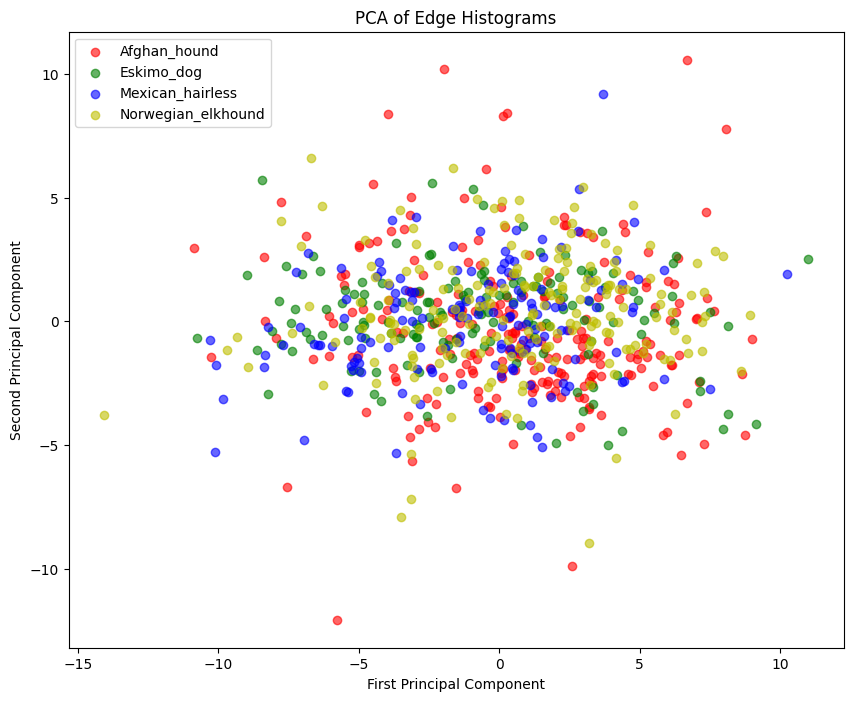

In [9]:
plt.figure(figsize=(10, 8))
colors = ["r", "g", "b", "y"]

for i in range(len(dog_classes)):
    mask = edge_labels == i
    plt.scatter(
        edge_pca_features[mask, 0],
        edge_pca_features[mask, 1],
        c=colors[i],
        label=dog_classes[i].split("-")[1],
        alpha=0.6,
    )

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA of Edge Histograms")
plt.legend()
plt.show()


## Part 3: Clustering Algorithms

We perform clustering on the 2D PCA-reduced edge histogram features using
various clustering algorithms: K-means (with random and k-means++
initialization), Bisecting K-means, Spectral Clustering, DBSCAN, and
Agglomerative Clustering with different linkage methods.


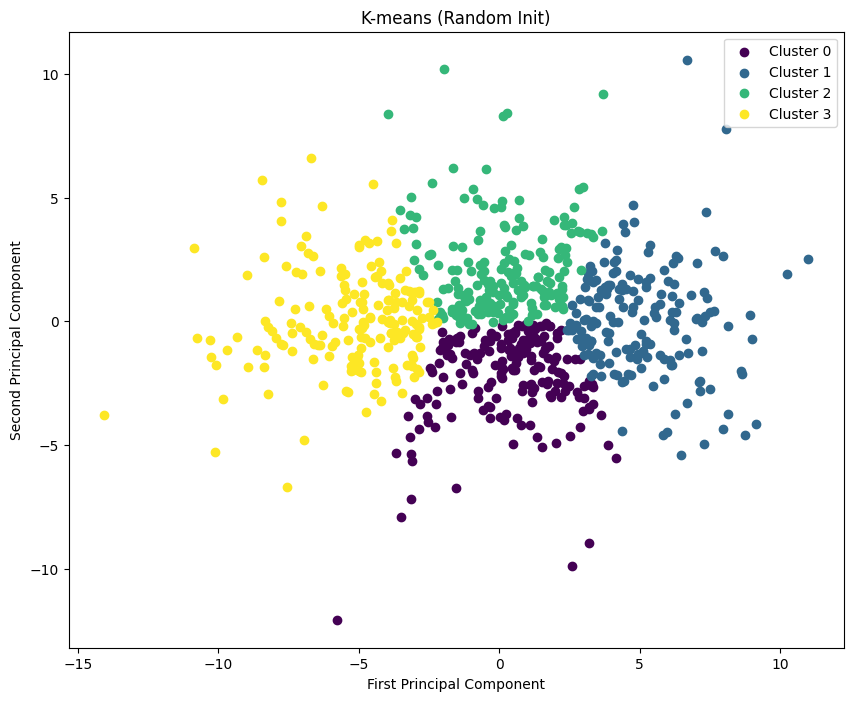

K-means (Random) Silhouette Score: 0.3379933308168226


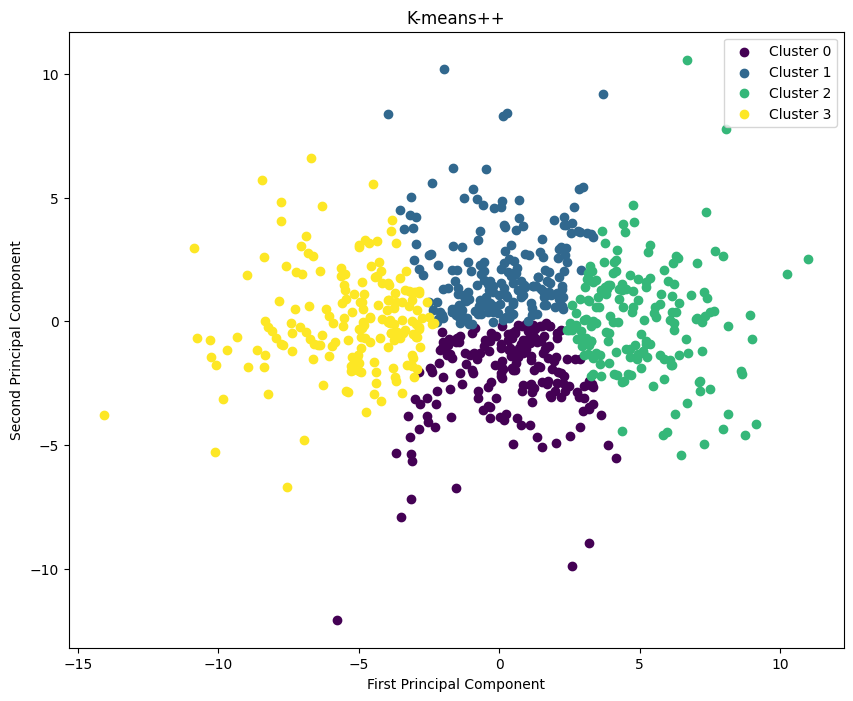

K-means++ Silhouette Score: 0.3374579230694607


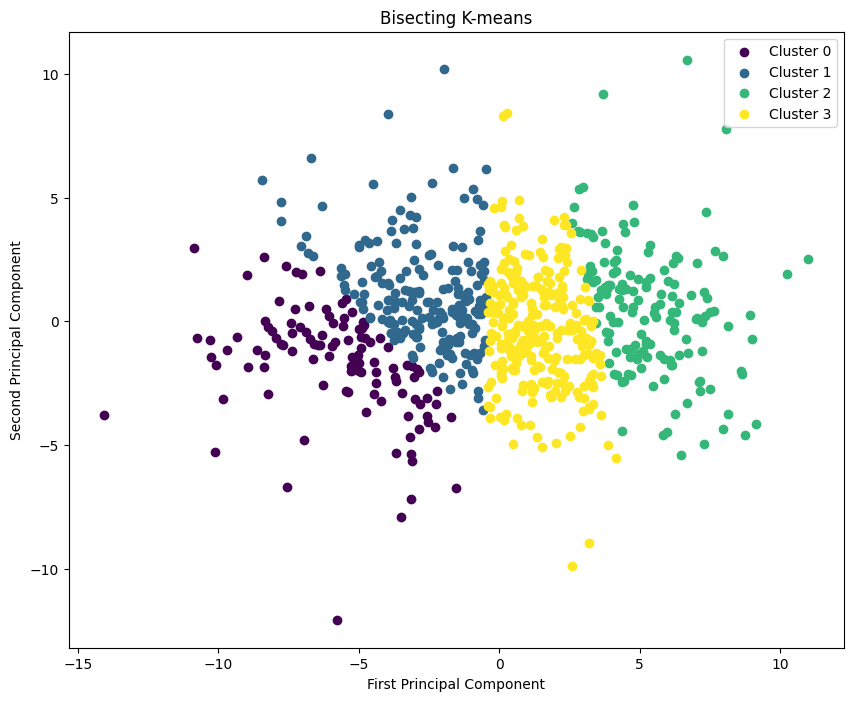

Bisecting K-means Silhouette Score: 0.27607385691748004


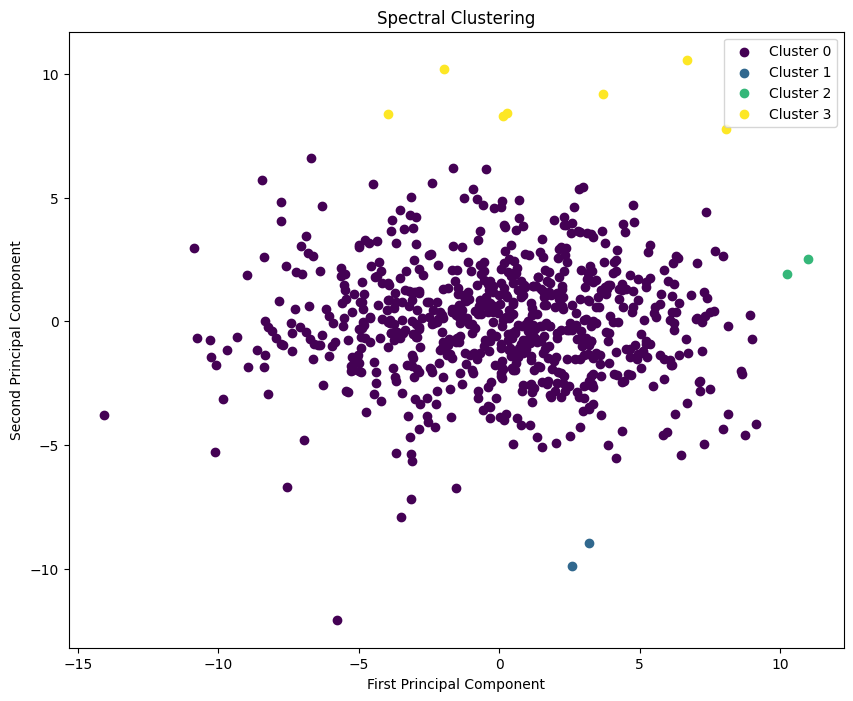

Spectral Clustering Silhouette Score: 0.299250133082433

Best DBSCAN parameters: eps=1.6, min_samples=2
DBSCAN Silhouette Score: 0.2459950396057084


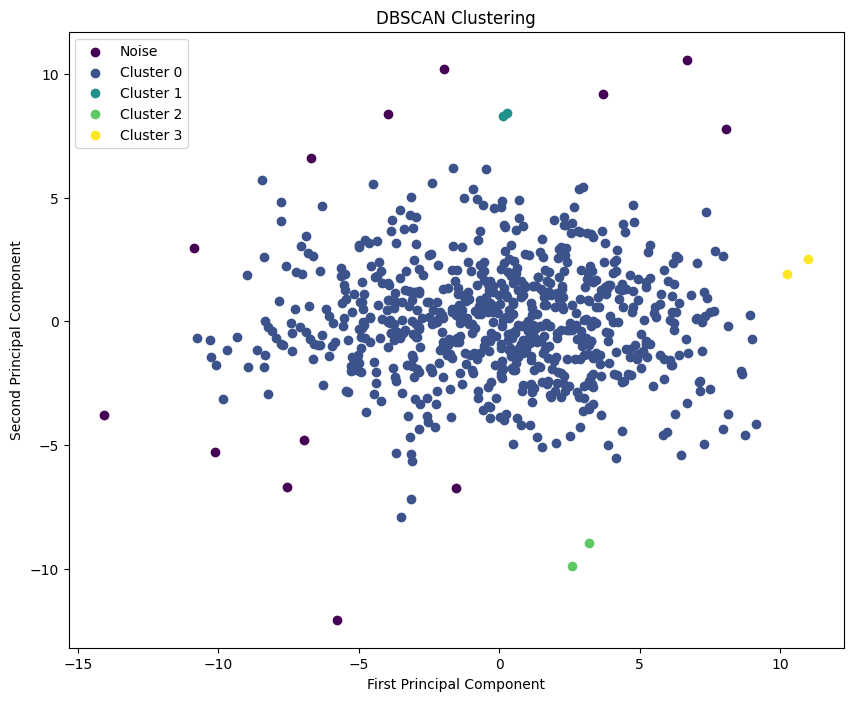

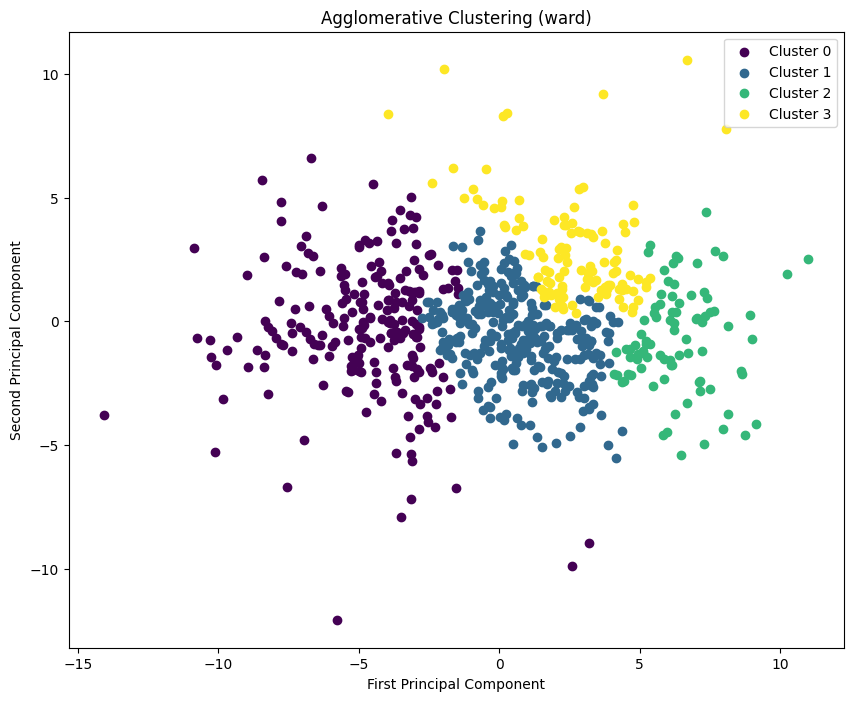

Agglomerative Clustering (ward) Silhouette Score: 0.3041593947831985


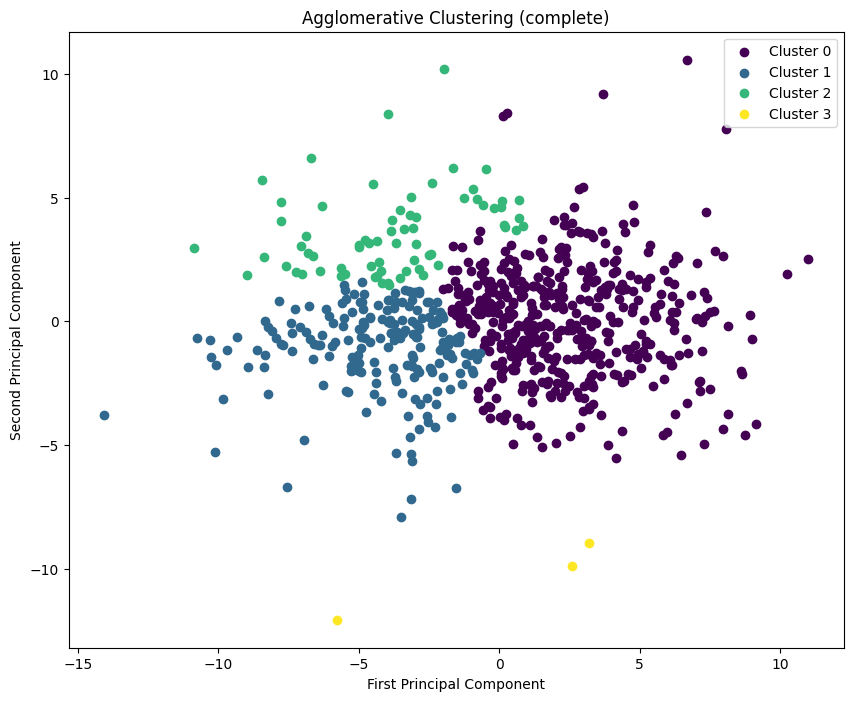

Agglomerative Clustering (complete) Silhouette Score: 0.3424149596157158


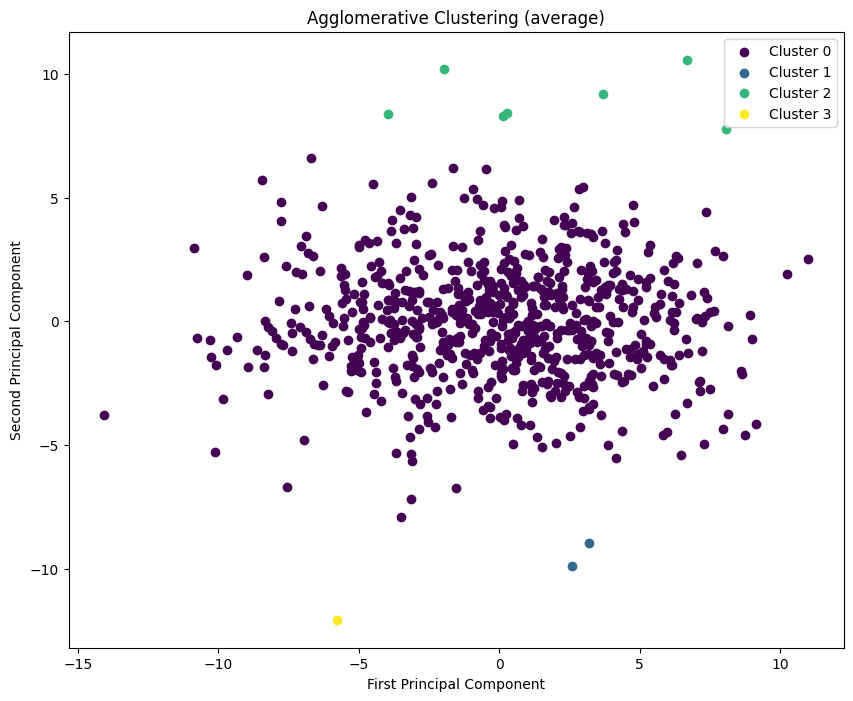

Agglomerative Clustering (average) Silhouette Score: 0.3474934755573497


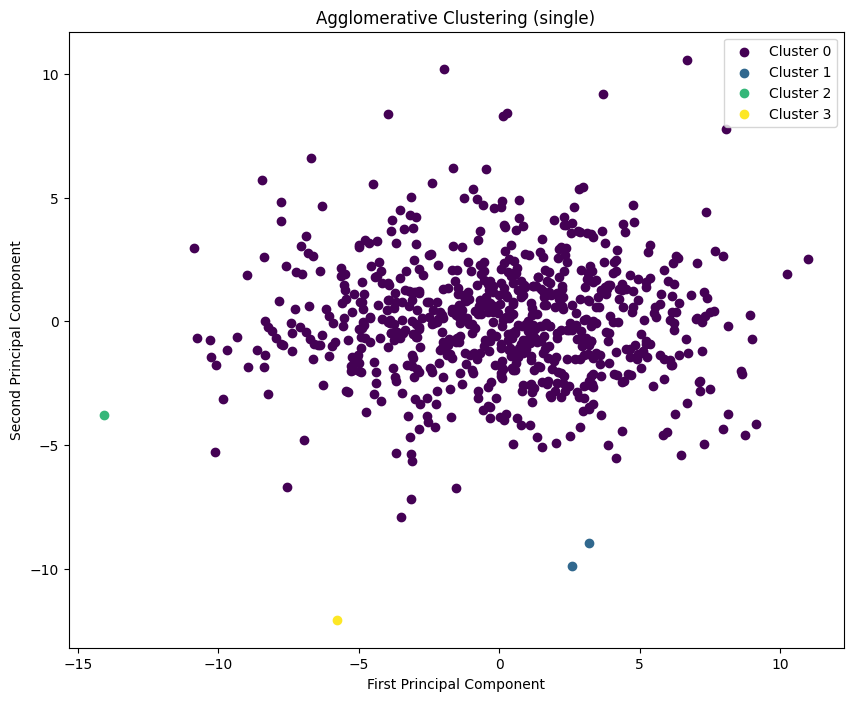

Agglomerative Clustering (single) Silhouette Score: 0.38549788092043646


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import (KMeans, BisectingKMeans, SpectralClustering, 
                             DBSCAN, AgglomerativeClustering)
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

def plot_clusters(X, labels, title):
    """Utility function to plot clustering results."""
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        if label == -1:
            label_name = 'Noise'
        else:
            label_name = f'Cluster {label}'
        plt.scatter(X[mask, 0], X[mask, 1], c=[color], label=label_name)
        
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()
    plt.show()

# Load the PCA-reduced features
X = np.load(os.path.join(edge_histograms_dir, "pca_features.npy"))
true_labels = np.load(os.path.join(edge_histograms_dir, "labels.npy"))

# 1. K-means variants
# a) K-means with random initialization
kmeans_random = KMeans(n_clusters=4, init='random', n_init=10, random_state=42)
kmeans_random_labels = kmeans_random.fit_predict(X)
plot_clusters(X, kmeans_random_labels, 'K-means (Random Init)')
print("K-means (Random) Silhouette Score:", silhouette_score(X, kmeans_random_labels))

# b) K-means++
kmeans_plus = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
kmeans_plus_labels = kmeans_plus.fit_predict(X)
plot_clusters(X, kmeans_plus_labels, 'K-means++')
print("K-means++ Silhouette Score:", silhouette_score(X, kmeans_plus_labels))

# c) Bisecting K-means
bisecting_kmeans = BisectingKMeans(n_clusters=4, init='random', random_state=42)
bisecting_labels = bisecting_kmeans.fit_predict(X)
plot_clusters(X, bisecting_labels, 'Bisecting K-means')
print("Bisecting K-means Silhouette Score:", silhouette_score(X, bisecting_labels))

# d) Spectral clustering
spectral = SpectralClustering(n_clusters=4, random_state=42)
spectral_labels = spectral.fit_predict(X)
plot_clusters(X, spectral_labels, 'Spectral Clustering')
print("Spectral Clustering Silhouette Score:", silhouette_score(X, spectral_labels))

# 2. DBSCAN
# Grid search for DBSCAN parameters
best_eps = 0
best_min_samples = 0
best_score = -1
best_labels = None

eps_range = np.arange(0.1, 2.0, 0.1)
min_samples_range = range(2, 10)

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Check if we got exactly 4 clusters (excluding noise points labeled as -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters == 4:
            # Calculate silhouette score (only for non-noise points)
            mask = labels != -1
            if np.sum(mask) > 1:  # Need at least 2 points for silhouette score
                score = silhouette_score(X[mask], labels[mask])
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples
                    best_labels = labels

if best_labels is not None:
    print(f"\nBest DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}")
    print("DBSCAN Silhouette Score:", best_score)
    plot_clusters(X, best_labels, 'DBSCAN Clustering')
else:
    print("Could not find DBSCAN parameters for exactly 4 clusters")

# 3. Agglomerative Clustering with different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
for linkage in linkage_methods:
    agglom = AgglomerativeClustering(n_clusters=4, linkage=linkage)
    agglom_labels = agglom.fit_predict(X)
    plot_clusters(X, agglom_labels, f'Agglomerative Clustering ({linkage})')
    print(f"Agglomerative Clustering ({linkage}) Silhouette Score:",
          silhouette_score(X, agglom_labels))


## Part 4: Clustering Evaluations

We evaluate the performance of each clustering method using the Fowlkes-Mallows
index and Silhouette Coefficient. The methods are then ranked based on these
metrics.



Detailed Evaluation Results:
--------------------------------------------------------------------------------
Method                    Fowlkes-Mallows      Silhouette          
--------------------------------------------------------------------------------
K-means (Random)          0.2714               0.3380              
K-means++                 0.2710               0.3375              
Bisecting K-means         0.2754               0.2761              
Spectral                  0.4994               0.2993              
DBSCAN                    0.5027               0.2460              
Agglomerative (ward)      0.2888               0.3042              
Agglomerative (complete)  0.3614               0.3424              
Agglomerative (average)   0.4992               0.3475              
Agglomerative (single)    0.5049               0.3855              

Ranking based on Fowlkes-Mallows index:
--------------------------------------------------
1. Agglomerative (single)    Score: 

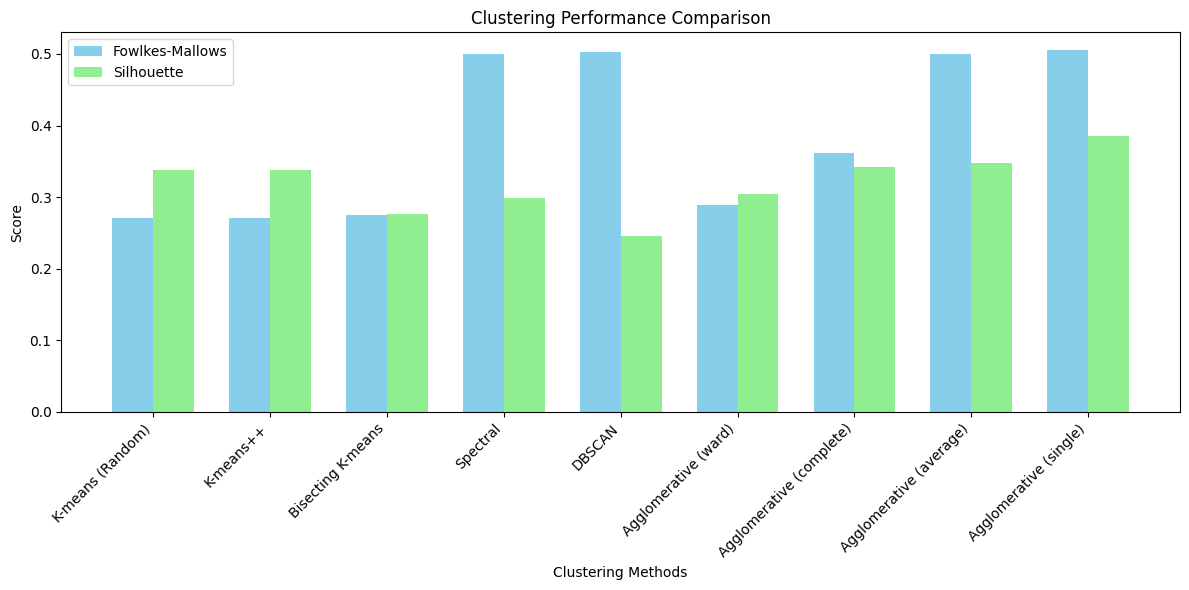

In [11]:

import numpy as np
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from collections import OrderedDict

X = np.load(os.path.join(edge_histograms_dir, "pca_features.npy"))
true_labels = np.load(os.path.join(edge_histograms_dir, "labels.npy"))

def evaluate_clustering(name, labels, X, true_labels):
    """Evaluate clustering using both metrics."""
    if -1 in labels:
        mask = labels != -1
        fm_score = fowlkes_mallows_score(true_labels[mask], labels[mask])
        silhouette = silhouette_score(X[mask], labels[mask])
    else:
        fm_score = fowlkes_mallows_score(true_labels, labels)
        silhouette = silhouette_score(X, labels)
    return fm_score, silhouette

results = OrderedDict()

kmeans_random = KMeans(n_clusters=4, init='random', n_init=10, random_state=42)
labels = kmeans_random.fit_predict(X)
results['K-means (Random)'] = evaluate_clustering('K-means (Random)', labels, X, true_labels)

kmeans_plus = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
labels = kmeans_plus.fit_predict(X)
results['K-means++'] = evaluate_clustering('K-means++', labels, X, true_labels)

bisecting_kmeans = BisectingKMeans(n_clusters=4, init='random', random_state=42)
labels = bisecting_kmeans.fit_predict(X)
results['Bisecting K-means'] = evaluate_clustering('Bisecting K-means', labels, X, true_labels)

spectral = SpectralClustering(n_clusters=4, random_state=42)
labels = spectral.fit_predict(X)
results['Spectral'] = evaluate_clustering('Spectral', labels, X, true_labels)

dbscan = DBSCAN(eps=1.6, min_samples=2)
labels = dbscan.fit_predict(X)
results['DBSCAN'] = evaluate_clustering('DBSCAN', labels, X, true_labels)

for linkage in ['ward', 'complete', 'average', 'single']:
    agglom = AgglomerativeClustering(n_clusters=4, linkage=linkage)
    labels = agglom.fit_predict(X)
    results[f'Agglomerative ({linkage})'] = evaluate_clustering(
        f'Agglomerative ({linkage})', labels, X, true_labels)

print("\nDetailed Evaluation Results:")
print("-" * 80)
print(f"{'Method':<25} {'Fowlkes-Mallows':<20} {'Silhouette':<20}")
print("-" * 80)
for method, (fm, silhouette) in results.items():
    print(f"{method:<25} {fm:<20.4f} {silhouette:<20.4f}")

fm_ranking = sorted(results.items(), key=lambda x: x[1][0], reverse=True)
print("\nRanking based on Fowlkes-Mallows index:")
print("-" * 50)
for rank, (method, (fm, _)) in enumerate(fm_ranking, 1):
    print(f"{rank}. {method:<25} Score: {fm:.4f}")

silhouette_ranking = sorted(results.items(), key=lambda x: x[1][1], reverse=True)
print("\nRanking based on Silhouette Coefficient:")
print("-" * 50)
for rank, (method, (_, silhouette)) in enumerate(silhouette_ranking, 1):
    print(f"{rank}. {method:<25} Score: {silhouette:.4f}")

plt.figure(figsize=(12, 6))

methods = list(results.keys())
fm_scores = [score[0] for score in results.values()]
silhouette_scores = [score[1] for score in results.values()]

x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, fm_scores, width, label='Fowlkes-Mallows', color='skyblue')
plt.bar(x + width/2, silhouette_scores, width, label='Silhouette', color='lightgreen')

plt.xlabel('Clustering Methods')
plt.ylabel('Score')
plt.title('Clustering Performance Comparison')
plt.xticks(x, methods, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
